# A wind profile modelled as the horizontal momentum $u(z,t)$ with the shear-stress as the only force

Let's attempt to simulate the following equations:
- $\rho \partial u/ \partial t = \partial \tau / \partial z$
- $u(z_{top},t) = u_{top}(t)$
Here $u(z,t) is a wind-profile at time $t$. We use $z=0$ at the surface and have a top of the profile at $z=z_{top}$.
We also need a boundary condition at the surface, which we'll discuss below.

As a first approximation and in an attempt to get a log-profile as the equilibrium we use:
- $\tau = -rho \nu \partial u / \partial z$
where $nu$ is the turbulent eddy viscosity.

Let's check the steady-state solution to this equation:
- $0 = \partial \tau / \partial z = -\rho \partial ( \nu \partial u / \partial z ) / \partial z$

Now substitute a log-profile of the form:
- $u = u_{*}/ \kappa \log(z/z_0)$
- $\partial u / \partial z = \frac{u_{*}}{\kappa z}$
- $\partial ( \nu \partial u / \partial z ) / \partial z = \partial ( \nu  \frac{u_{*}}{\kappa z}) / \partial z$

Thus we get a log-profile, for example in the case of $\nu = \kappa u_{*} z$. Or to avoid $u_{*}$ in the formula for $\nu$, we could use
$\nu = \kappa^2 z^2 | \partial u / \partial z |$

For a log-profile the boundary condition at the surface is a bit of a problem since the log function does not go to zero there. In reality the layer close to the surface is not well decribed by the log-profile, but is known as a laminar layer and a transition zone. Here, we will not attempt this close to the surface, but instead
use the log-profile directly to provide a relationship at height $z_{surf} > z0$.
- $u(z_{surf} = u_{*}/ \kappa \log(z_{surf}/z_0)$

We can rewrite this equation to give the stress $\tau$ at height $z=z_{surf}$:
- $\tau_{surf} = \rho u_{*}^2 = \frac{\rho \kappa^2}{\log(z_{surf}/z_0)^2} u(z_{surf})^2$ 

where the term $\frac{\kappa^2}{\log(z_{surf}/z_0)^2}$ is also known as the drag-coefficient $C_d$. In this equation $z_0$ describes the roughness of the surface.

For discretization we'll use a staggered grid, where the stresses are defined at the interface between the layers and the velocities at the center of the layers.

In [1]:
# import some packages using the Project.toml file
using Pkg
Pkg.activate(".")
# Pkg.instantiate() # Instanciate the environment if needed at first use of this repository
using Plots
using OrdinaryDiffEq
using LaTeXStrings

  Activating project at `~/src_nobackup/wind_over_water.jl.git`


In [12]:
# Settings
z_top  = 10.0 #height at top of profile
u_top  = 5.0  #wind speed at top of profile
n_layer= 20
dz     = z_top / (n_layer+0.5)  #height step. Top layer has u at the center and is not part of the profile
z_surf = 0.5 * dz
kappa  = 0.4 #von Karman constant
z0     = 0.01 #surface roughness length
cd     = kappa^2 / (log(z_surf/z0))^2 #drag coefficient

# vertical grid
z_u   = dz * (0.5:1:n_layer) #height at u points
z_tau = dz * (0.0:1:n_layer) #height at tau points

# initial wind profile
u0 = collect(u_top * (z_u / z_top)) #start with a linear profile
#u0 = collect(u_top * log.(z_u/z0) / log.(z_top/z0)) #start with a log profile

# time span
tspan = (0.0, 300.0) #start and end time in seconds

# du/dt operator
function log_profile(du, u, p, t)
    # stresses (divided by rho)
    tau = zeros(n_layer+1)
    tau[1] = cd * u[1] * abs(u[1]) #only for positive u
    u_star = sqrt(tau[1])
    tau[end] = kappa * u_star * z_top * (u_top - u[end]) / (z_top - z_u[end])
    tau[2:(end-1)] .= kappa * u_star * z_tau[2:(end-1)] .* (u[2:end] - u[1:(end-1)])./dz
    # @show u_top, u[end], u[end-1]
    # @show z_top, z_u[end]
    # @show tau[end]
    # @show tau
    #change of velocity
    du[:] .= (tau[2:end] - tau[1:(end-1)]) ./ dz 
end

## test the operator
# du=zeros(n_layer)
# log_profile(du, u0, [], 0.0)
# @show du

#Simulate the equation
prob = ODEProblem(log_profile, u0, tspan)
sol = solve(prob, Rosenbrock23(autodiff=false))

@show sol.u[end]'

(sol.u[end])' = [2.3237370213024047 3.054214458029406 3.4212558512277353 3.667191134737195 3.8525600500560624 4.0015616795144355 4.126287643238396 4.233643378841715 4.327942652501055 4.412060225785501 4.488007957319764 4.557248908288939 4.620880490694421 4.679747123556399 4.734512620625217 4.785708425872357 4.833766758703017 4.879043998876203 4.921837566488168 4.962398353304002]


1×20 adjoint(::Vector{Float64}) with eltype Float64:
 2.32374  3.05421  3.42126  3.66719  …  4.83377  4.87904  4.92184  4.9624

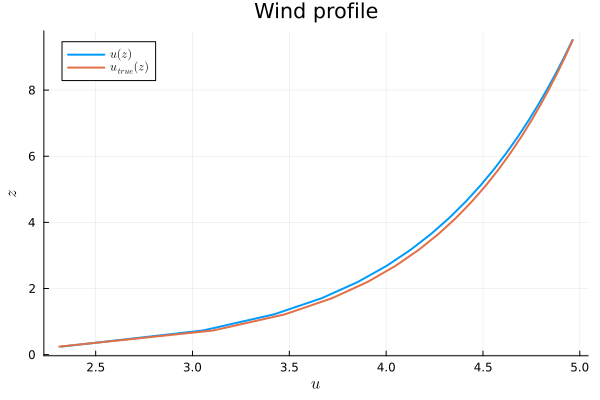

In [13]:
u_true = u_top * log.(z_u/z0) / log.(z_top/z0)

plot(sol.u[end],z_u,label=L"u(z)",xlabel=L"u",ylabel=L"z",title="Wind profile",lw=2)
plot!(u_true,z_u,label=L"u_{true}(z)",lw=2)
